# LDA Topic Modeling

## Table of Contents

- Data Loading and Exploration
- Text Preprocessing
- Corpus Preparation and LDA Training
- Topic Analysis and Evaluation

In [1]:
# Standard Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# NLTK for Text Preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
import re

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

# Progress Bar
from tqdm import tqdm

# Gensim for LDA Topic Modeling
import gensim
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel

# PyLDAvis for Topic Visualization
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data Loading and Exploration

In [2]:
beaverton_url = 'https://drive.google.com/uc?export=download&id=173t6vMYcbSED81IOmg0MbhHsrSFSiF21'
billnye_url = 'https://drive.google.com/uc?export=download&id=1w1Xm-TQfcPfGICM_8_LQiWSqzf8WUk8N'
georgetakei_url = 'https://drive.google.com/uc?export=download&id=1_Ck9S2aW9cBQQrqoTiNLRmvRu4WvPn8y'
cookiemonster_url = 'https://drive.google.com/uc?export=download&id=10Av-HVklZA4Su3TcvSpxU6nS8At9mJ05'
neiltyson_url = 'https://drive.google.com/uc?export=download&id=1GSKxxldXe--HE4gSYAEn2ip2vS4bXKMM'
stephenking_url = 'https://drive.google.com/uc?export=download&id=1Oq2pUCv0d7x4tDKX1E-3hgdSAuXcZtVU'
twentytwo_minutes_url = 'https://drive.google.com/uc?export=download&id=1B2zwAJYdw_9skXAFbn7QIs6uyIikje5W'

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
beaverton = pd.read_excel(beaverton_url, engine='openpyxl')
beaverton.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tweet-id,tweet-text,tweet-author,tweet-timestamp-date
0,1,Heartwarming: This man reconnected with his mo...,The Beaverton,2022-03-05
1,2,OP-ED: Big Pharma put all of the chips in the ...,The Beaverton,2022-03-04
2,3,Make every day a 'talking to Americans about t...,The Beaverton,2022-03-04
3,4,Single drop of sweat falls down local dad’s fa...,The Beaverton,2022-03-04
4,5,100% of Canadians pretty sure they’ve had COVI...,The Beaverton,2022-03-03


In [4]:
billnye = pd.read_excel(billnye_url, engine='openpyxl')
billnye.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tweet-id,tweet-text,tweet-author,tweet-timestamp-date
0,1,"Happy Twosday, people(s). That’s right, it’s 2...",Bill Nye,2022-02-22
1,2,Dr. King would be 93 years old this week. The ...,Bill Nye,2022-01-17
2,3,Happy Isaac Newton’s Birthday James Webb Space...,Bill Nye,2021-12-25
3,4,"Please, consider the following… my new VR Spac...",Bill Nye,2021-12-14
4,5,Winter tornadoes… warm winter in the south & c...,Bill Nye,2021-12-12


In [5]:
georgetakei = pd.read_excel(georgetakei_url, engine='openpyxl')
georgetakei.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tweet-id,tweet-text,tweet-author,tweet-timestamp-date
0,1,He is still sorely missed. 💕 What is your favo...,georgetakei,2022-03-12
1,2,It’s terrifying but true. The GOP has become t...,georgetakei,2022-03-12
2,3,This is not normal.,georgetakei,2022-03-12
3,4,"Very well put, indeed.",georgetakei,2022-03-12
4,5,"With the former guy, mockery is the best polic...",georgetakei,2022-03-12


In [6]:
cookiemonster = pd.read_excel(cookiemonster_url, engine='openpyxl')
cookiemonster.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tweet-id,tweet-text,tweet-author,tweet-timestamp-date
0,1,"Today, me so thankful for chefs like me friend...",MeCookieMonster,2022-03-08
1,2,You can’t spell cookie without “oo.” Speaking ...,MeCookieMonster,2022-02-25
2,3,Me so grateful @SesameErnie\n. Me think sharin...,MeCookieMonster,2022-02-17
3,4,What do me love? Friends. Family. Cookies. Ple...,MeCookieMonster,2022-02-14
4,5,"Dipping cookies in milk? Me get it, but who ha...",MeCookieMonster,2022-01-28


In [7]:
neiltyson = pd.read_excel(billnye_url, engine='openpyxl')
neiltyson.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tweet-id,tweet-text,tweet-author,tweet-timestamp-date
0,1,"Happy Twosday, people(s). That’s right, it’s 2...",Bill Nye,2022-02-22
1,2,Dr. King would be 93 years old this week. The ...,Bill Nye,2022-01-17
2,3,Happy Isaac Newton’s Birthday James Webb Space...,Bill Nye,2021-12-25
3,4,"Please, consider the following… my new VR Spac...",Bill Nye,2021-12-14
4,5,Winter tornadoes… warm winter in the south & c...,Bill Nye,2021-12-12


In [8]:
stephenking = pd.read_excel(stephenking_url, engine='openpyxl')
stephenking.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tweet-id,tweet-text,tweet-author,tweet-timestamp-date
0,1,What kind of dinosaur writes romance novels? A...,StephenKing,2022-03-05
1,2,"Molly, aka the Thing of Evil, fools my friend ...",StephenKing,2022-02-25
2,3,Two questions (and a codicil) about MANIFEST: ...,StephenKing,2022-02-25
3,4,What most of us learned as kids on the playgro...,StephenKing,2022-02-23
4,5,"I need baseball! Come on you guys, stop being ...",StephenKing,2022-02-16


In [9]:
twentytwo_minutes = pd.read_excel(twentytwo_minutes_url, engine='openpyxl')
twentytwo_minutes.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tweet-id,tweet-text,tweet-author,tweet-timestamp-date
0,1,"And in lighter news this week: Nope, sorry. We...",22Minutes,2022-03-03 00:00:00
1,2,Dee Snider of Twisted Sister says he approves ...,22Minutes,2022-03-03 00:00:00
2,3,Tim Hortons will be releasing their own line o...,22Minutes,2022-03-03 00:00:00
3,4,A new survey shows that 1 in 8 people suffer f...,22Minutes,2022-03-02 00:00:00
4,5,The Bank of Canada has raised its interest rat...,22Minutes,2022-03-02 00:00:00


In [10]:
beaverton['account'] = 'The Beaverton'
billnye['account'] = 'Bill Nye'
georgetakei['account'] = 'George Takei'
cookiemonster['account'] = 'Cookie Monster'
neiltyson['account'] = 'Neil deGrasse Tyson'
stephenking['account'] = 'Stephen King'
twentytwo_minutes['account'] = 'This Hour Has 22 Minutes'

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
data = pd.concat([beaverton, billnye, georgetakei, cookiemonster, neiltyson, stephenking, twentytwo_minutes], ignore_index=True)
data.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tweet-id,tweet-text,tweet-author,tweet-timestamp-date,account
0,1,Heartwarming: This man reconnected with his mo...,The Beaverton,2022-03-05 00:00:00,The Beaverton
1,2,OP-ED: Big Pharma put all of the chips in the ...,The Beaverton,2022-03-04 00:00:00,The Beaverton
2,3,Make every day a 'talking to Americans about t...,The Beaverton,2022-03-04 00:00:00,The Beaverton
3,4,Single drop of sweat falls down local dad’s fa...,The Beaverton,2022-03-04 00:00:00,The Beaverton
4,5,100% of Canadians pretty sure they’ve had COVI...,The Beaverton,2022-03-03 00:00:00,The Beaverton


In [12]:
data.tail()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tweet-id,tweet-text,tweet-author,tweet-timestamp-date,account
1071,196,A student at U of T is launching a city-wide s...,22Minutes,2021-09-17 00:00:00,This Hour Has 22 Minutes
1072,197,New poll shows nearly half of Canadians don’t ...,22Minutes,2021-09-17 00:00:00,This Hour Has 22 Minutes
1073,198,Apple has introduced the iPhone 13! Huge! Mass...,22Minutes,2021-09-16 00:00:00,This Hour Has 22 Minutes
1074,199,The Price Is Right is celebrating its 50th yea...,22Minutes,2021-09-15 00:00:00,This Hour Has 22 Minutes
1075,200,Some restaurants are reporting a shortage of c...,22Minutes,2021-09-15 00:00:00,This Hour Has 22 Minutes


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1076 entries, 0 to 1075
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   tweet-id              1076 non-null   int64 
 1   tweet-text            1076 non-null   object
 2   tweet-author          1076 non-null   object
 3   tweet-timestamp-date  1076 non-null   object
 4   account               1076 non-null   object
dtypes: int64(1), object(4)
memory usage: 42.2+ KB


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Text Preprocessing

In [14]:
# to initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
def preprocess_text(text):
    """
    Preprocesses text by expanding contractions, removing punctuation, tokenizing,
    lowercasing, removing stopwords and numbers, lemmatizing,
    and filtering short words (≤2 characters). Returns a list of cleaned tokens.
    """

    text = re.sub(r"n't", " not", text) # "can't" → "can not"
    text = re.sub(r"'m", " am", text) # "I'm" → "I am"
    text = re.sub(r"'re", " are", text) # "You're" → "You are"
    text = re.sub(r"'ll", " will", text) # "I'll" → "I will"
    text = re.sub(r"'ve", " have", text) # "I've" → "I have"
    text = re.sub(r"'s", "", text) # "child's" → "child"

    text = re.sub(r"[^\w\s]", "", text) # removes all punctuation after expanding contractions

    tokens = word_tokenize(text) # tokenization

    tokens = [token.lower() for token in tokens] # lowercasing

    tokens = [token for token in tokens if token not in stop_words] # removes stop words

    tokens = [lemmatizer.lemmatize(token) for token in tokens] # lemmatization

    # to remove short words (<=2 characters, except "I" and "am")
    # "I" is a valid pronoun and often important for sentence meaning.
    # "am" is a verb and critical for sentence structure (e.g., "I am happy" → "happy" loses meaning).
    tokens = [token for token in tokens if len(token) > 2 or token in {"i", "am"}]

    tokens = [token for token in tokens if not token.isdigit()] # removes numbers

    return tokens

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
tqdm.pandas() # tqdm.pandas() integrates the tqdm progress bar with pandas, allowing you to track progress when using .apply() on DataFrames or Series.

data['processed_tweet_text'] = data['tweet-text'].progress_apply(preprocess_text)
data[['tweet-text', 'processed_tweet_text']].head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 1076/1076 [00:06<00:00, 169.25it/s]


,tweet-text,processed_tweet_text
0,Heartwarming: This man reconnected with his mo...,"[heartwarming, man, reconnected, mom, could, a..."
1,OP-ED: Big Pharma put all of the chips in the ...,"[oped, big, pharma, put, chip, vaccine, get, ps5]"
2,Make every day a 'talking to Americans about t...,"[make, every, day, talking, american, healthca..."
3,Single drop of sweat falls down local dad’s fa...,"[single, drop, sweat, fall, local, dad, face, ..."
4,100% of Canadians pretty sure they’ve had COVI...,"[canadian, pretty, sure, theyve, covid, already]"


In [17]:
for text in data['processed_tweet_text'].head(25):
    print(text)

['heartwarming', 'man', 'reconnected', 'mom', 'could', 'ask', 'tax']
['oped', 'big', 'pharma', 'put', 'chip', 'vaccine', 'get', 'ps5']
['make', 'every', 'day', 'talking', 'american', 'healthcare', 'system', 'level', 'smug', 'day', 'shirt']
['single', 'drop', 'sweat', 'fall', 'local', 'dad', 'face', 'tell', 'daycare', 'worker', 'child', 'doesnt', 'runny', 'nose']
['canadian', 'pretty', 'sure', 'theyve', 'covid', 'already']
['local', 'fiancé', 'insists', 'buying', 'wedding', 'ring', 'bulk', 'totally', 'normal']
['congressional', 'bouncer', 'apologize', 'admitting', 'rowdy', 'bachelorette', 'party', 'state', 'union', 'stateoftheunion']
['immersive', 'art', 'experience', 'really', 'two', 'sens']
['political', 'cartoonist', 'mistaken', 'impression', 'political', 'cartoonist', 'never', 'important']
['climate', 'change', 'considering', 'makeover', 'stand', 'amongst', 'shiny', 'new', 'calamity']
['scientist', 'invents', 'time', 'travel', 'mock', 'people', 'thought', 'thing', 'bad']
['quiz', 'r

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Corpus Preparation and LDA Training

Topic modelling involves counting words and grouping similar word patterns to describe topics within the data. If the model knows the word frequency, and which words often appear in the same document, it will discover patterns that can group different words together.

We start by converting a collection of words into a bag of words, which is a list of tuples (word_id, word_frequency). `gensim.corpora.Dictionary` is a great tool for this:


In [18]:
# Creates a dictionary where each unique word gets a unique integer ID.
# The dictionary stores how many times each word appears across all documents.
id2word = corpora.Dictionary(data['processed_tweet_text'])

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
# Converts each document (text, which is a list of words) into a sparse vector.
corpus = [id2word.doc2bow(text) for text in data['processed_tweet_text']]
print(corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
[[(id2word[i], freq) for i, freq in doc] for doc in corpus[:1]]

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[('ask', 1),
  ('could', 1),
  ('heartwarming', 1),
  ('man', 1),
  ('mom', 1),
  ('reconnected', 1),
  ('tax', 1)]]

### Why These Parameters?

- `num_topics=5`: Each account likely discusses a few main themes. Using five topics per account helps keep topics clear and meaningful without making them too broad or too specific. **Experimenting with coherence scores** can determine the optimal number.
- `passes=50`: Runs the model enough times to find good topics without wasting time on extra passes that don't add much improvement.
- `update_every=1`: Updates the model after each batch of documents, making training faster and more memory-efficient, especially for large datasets.
- `chunksize=200`: Processes 200 documents at a time, which makes training faster and helps the model find more stable topics.
- `alpha='auto'`: Automatically adjusts how many topics each document contains, so the model can decide if a document should focus on just one topic or multiple topics.
- `per_word_topics=False`: Speeds up processing by skipping extra details about individual words, which are not usually needed for topic analysis.

In [21]:
# Train a single LDA model on all accounts together
lda_model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=15,  # Adjust based on coherence score testing
    passes=50,
    update_every=1,
    chunksize=200,
    alpha='auto',
    per_word_topics=False
)

# The coherence score measures how well the words in a topic are related, helping us evaluate the quality of the LDA model.
# A higher coherence score means better topics, making the model more useful!
# The coherence score in LDA topic modeling typically ranges between 0 and 1, but it does not have strict theoretical bounds.
# A higher coherence score (~0.5 to 0.7) means the topics are well-formed and useful!
coherence_model = CoherenceModel(
    model=lda_model,
    texts=data['processed_tweet_text'],
    dictionary=id2word,
    coherence='c_v'
)
coherence_score = coherence_model.get_coherence()

# Print the overall coherence score and topics
print(f"LDA Model Trained on All Accounts (Coherence Score: {coherence_score:.4f})")
print("=" * 100)

for topic_id, topic in lda_model.show_topics(formatted=True, num_words=10):
    print(f"Topic {topic_id + 1}: {topic}")

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LDA Model Trained on All Accounts (Coherence Score: 0.4930)
Topic 11: 0.033*"around" + 0.027*"tweet" + 0.024*"phone" + 0.024*"next" + 0.022*"spacecraft" + 0.021*"christmas" + 0.020*"mar" + 0.018*"enough" + 0.017*"track" + 0.015*"hope"
Topic 14: 0.057*"call" + 0.029*"moon" + 0.026*"average" + 0.023*"apple" + 0.017*"dark" + 0.016*"try" + 0.016*"amazing" + 0.016*"seems" + 0.015*"order" + 0.014*"ground"
Topic 10: 0.063*"show" + 0.057*"canadian" + 0.035*"new" + 0.034*"half" + 0.020*"survey" + 0.016*"tell" + 0.015*"youre" + 0.015*"went" + 0.015*"line" + 0.015*"test"
Topic 8: 0.033*"want" + 0.028*"find" + 0.026*"home" + 0.022*"game" + 0.021*"book" + 0.017*"use" + 0.017*"gas" + 0.016*"thinking" + 0.015*"young" + 0.014*"true"
Topic 6: 0.027*"stop" + 0.026*"old" + 0.024*"would" + 0.022*"food" + 0.020*"fight" + 0.019*"winter" + 0.018*"may" + 0.016*"pretty" + 0.015*"honor" + 0.014*"tim"
Topic 7: 0.082*"cooky" + 0.044*"eat" + 0.037*"friend" + 0.033*"lot" + 0.032*"thing" + 0.027*"like" + 0.027*"dat"

## Topic Analysis and Evaluation

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


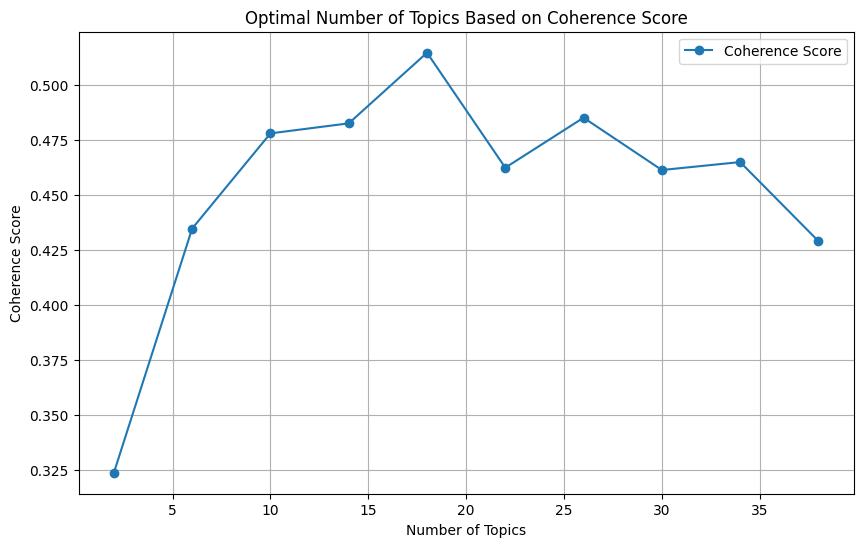

In [22]:
def compute_coherence_values(dictionary, corpus, texts, start=2, limit=40, step=4):
    coherence_values = []
    model_list = []
    num_topics_list = range(start, limit + 1, step)

    for num_topics in num_topics_list:
        model = gensim.models.LdaModel(
            corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=50,
            update_every=1, chunksize=200, alpha='auto', per_word_topics=False)
        model_list.append(model)

        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())

    return model_list, coherence_values, num_topics_list

model_list, coherence_values, num_topics_list = compute_coherence_values(
    dictionary=id2word,
    corpus=corpus,
    texts=data['processed_tweet_text'],
    start=2,
    limit=40,
    step=4
)

plt.figure(figsize=(10, 6))
plt.plot(num_topics_list, coherence_values, marker='o', linestyle='-')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Optimal Number of Topics Based on Coherence Score")
plt.legend(["Coherence Score"], loc='best')
plt.grid(True);

It looks like the **coherence score increases with the increase in the number of topics**. We will use the model with the highest coherence score:

In [23]:
# Find the index of the best coherence score
best_result_index = coherence_values.index(max(coherence_values))

# Select the optimal model based on the highest coherence score
optimal_model = model_list[best_result_index]

# Get the best number of topics
best_num_topics = num_topics_list[best_result_index]

# Print the best number of topics and its coherence score
print(f"The optimal number of topics is {best_num_topics}, achieving the highest coherence score of {coherence_values[best_result_index]:.4f}.")

# Display the top topics from the optimal model
print("=" * 100)
for topic_id, topic in optimal_model.show_topics(formatted=True, num_words=10):
    print(f"Topic {topic_id + 1}: {topic}")

The optimal number of topics is 18, achieving the highest coherence score of 0.5145.
Topic 9: 0.026*"bad" + 0.026*"there" + 0.025*"hortons" + 0.025*"tim" + 0.022*"winter" + 0.020*"full" + 0.020*"claim" + 0.018*"theyve" + 0.016*"way" + 0.013*"metal"
Topic 15: 0.052*"kid" + 0.037*"pretty" + 0.024*"party" + 0.019*"called" + 0.019*"order" + 0.018*"issue" + 0.016*"wish" + 0.012*"try" + 0.011*"stand" + 0.011*"smaller"
Topic 14: 0.087*"think" + 0.034*"love" + 0.034*"would" + 0.030*"thats" + 0.028*"fight" + 0.021*"honor" + 0.018*"clown" + 0.017*"good" + 0.015*"opportunity" + 0.012*"play"
Topic 7: 0.033*"international" + 0.032*"even" + 0.025*"moon" + 0.025*"space" + 0.023*"remember" + 0.022*"asteroid" + 0.021*"american" + 0.021*"station" + 0.021*"astronaut" + 0.020*"took"
Topic 5: 0.067*"best" + 0.037*"guy" + 0.032*"space" + 0.028*"human" + 0.026*"story" + 0.025*"exploreplanets" + 0.023*"average" + 0.020*"tell" + 0.019*"fall" + 0.017*"exploration"
Topic 17: 0.186*"say" + 0.062*"thing" + 0.052*"

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Let's see how the words are clustered using pyLDAVis.

In [24]:
p = gensimvis.prepare(optimal_model, corpus, id2word)
p

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12    -0.393140 -0.053168       1        1  16.505338
1     -0.032462  0.229514       2        1   9.366263
5      0.031816 -0.185994       3        1   7.474106
9      0.025933 -0.104013       4        1   5.817694
3     -0.012970  0.122069       5        1   5.581070
17     0.026745 -0.023145       6        1   5.534992
11    -0.010753  0.042969       7        1   5.421346
7      0.042606 -0.035331       8        1   5.066688
2      0.023690  0.002527       9        1   4.964558
16     0.037472 -0.078297      10        1   4.888056
10     0.034963  0.000836      11        1   4.695236
15     0.022439  0.028239      12        1   4.556992
6      0.042272  0.003407      13        1   4.368319
4      0.039558 -0.004763      14        1   4.159517
0      0.024236  0.004182      15        1   3.974209
13     0.023315  0.025526      16        1   3.493860
14     0.031032  0.017076      17        1   2.078519
8      0.043247  0.008368      18        1   2.053237, topic_info=          Term        Freq       Total Category  logprob  loglift
81         new  137.000000  137.000000  Default  30.0000  30.0000
148        say  113.000000  113.000000  Default  29.0000  29.0000
16         day  171.000000  171.000000  Default  28.0000  28.0000
663        one  100.000000  100.000000  Default  27.0000  27.0000
375       like   92.000000   92.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
566        try    1.419892    7.941845  Topic18  -5.1886   2.1642
1056   jupiter    1.100384    3.708203  Topic18  -5.4436   2.6709
573      great    1.259623   20.283558  Topic18  -5.3084   1.1068
360    tonight    1.099030   14.940491  Topic18  -5.4448   1.2761
920   everyone    1.055067   21.042232  Topic18  -5.4856   0.8928

[714 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
960      16  0.418494        3ply
1215     12  0.866717         4th
829      14  0.908227        able
914       2  0.854841      access
805       3  0.841518  accomplish
...     ...       ...         ...
591      12  0.833253        youd
1124     11  0.899696       young
381       1  0.253959       youre
381       4  0.152376       youre
381       5  0.558710       youre

[836 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 2, 6, 10, 4, 18, 12, 8, 3, 17, 11, 16, 7, 5, 1, 14, 15, 9])

In [25]:
pyLDAvis.save_html(p, "lda_visualization.html")

print("LDA visualization saved as lda_visualization.html")

LDA visualization saved as lda_visualization.html


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
